# Setup

## Imports

In [2]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


0

## Logger Setups

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [5]:
#Mode10 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode10/Mode10.json");
Models = [SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode$i/Mode$i.json") for i in 1:10];

In [4]:
for i in 1:length(Models)
    println("Mode $(i): $(Models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"])")
end
println("----------------")
for i in 1:length(Models)
    println("Mode $(i): $(Models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"])")
end

Mode 1: 338.25935369473007
Mode 2: 204.92182562001517
Mode 3: 205.05411739244443
Mode 4: 220.40941624060824
Mode 5: 197.0997733929405
Mode 6: 378.9353606773365
Mode 7: 291.2202399349962
Mode 8: 304.0189696434496
Mode 9: 361.80610665516963
Mode 10: 335.220050434477
----------------
Mode 1: 0.295
Mode 2: 0.595
Mode 3: 0.735
Mode 4: 0.84
Mode 5: 1.21
Mode 6: 0.7705
Mode 7: 1.22
Mode 8: 1.545
Mode 9: 1.68
Mode 10: 2.5


In [5]:
Models[3].CandD_Ops

Dict{Any, Any} with 4 entries:
  "Mode3 Dephasing"    => Quantum Object:   type=Operator   dims=[10, 10]   siz…
  "Transmon Collapse"  => Quantum Object:   type=Operator   dims=[10, 10]   siz…
  "Transmon Dephasing" => Quantum Object:   type=Operator   dims=[10, 10]   siz…
  "Mode3 Collapse"     => Quantum Object:   type=Operator   dims=[10, 10]   siz…

# Getting Data

## Running Data Gathering

In [6]:
f0g1_res = []

for i in 1:10
    println("Running Mode $i")
    ψ = Models[i].dressed_states[(2,0)]
    push!(f0g1_res, SC.Dynamics.RunPulseSequence(Models[i], ψ, ["sb_f0g1"]))
end

Running Mode 1
The Name for this run is: Operator_Sequence_Tue-Nov-19-24.23.53
It is being saved at: Data/
[2024-11-19 23:53:23] Info: Running operator sb_f0g1
[2024-11-19 23:53:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-19 23:53:33] Info: Time Evolution Complete
[2024-11-19 23:53:33] Info: Saving Steps
[2024-11-19 23:53:38] Info: Done with Step_1
[2024-11-19 23:53:38] Info: Done With Running Sequence
[2024-11-19 23:53:38] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Running Mode 2
The Name for this run is: Operator_Sequence_Tue-Nov-19-24.23.53
It is being saved at: Data/
[2024-11-19 23:53:39] Info: Running operator sb_f0g1
[2024-11-19 23:53:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-19 23:53:43] Info: Time Evolution Complete
[2024-11-19 23:53:43] Info: Saving Steps
[2024-11-19 23:53:43] Info: Done with Step_1
[2024-11-19 23:53:43] Info: Done With Running Sequence
[2024-11-19 23:53:43] Info: Loading Data
Running Mode 3
The Name for this run is: Operator_Sequence_Tue-Nov-19-24.23.53
It is being saved at: Data/
[2024-11-19 23:53:43] Info: Running operator sb_f0g1
[2024-11-19 23:53:43] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-19 23:53:47] Info: Time Evolution Complete
[2024-11-19 23:53:47] Info: Saving Steps
[2024-11-19 23:53:48] Info: Done with Step_1
[2024-11-19 

## Plots

In [7]:
for i in 1:10
    axis_kwargs = Dict{Any, Any}("title" => "Lossless f0g1 for  Mode $i")
    SC.Dynamics.PlotSingleModeEvolution(Models[i], f0g1_res[i]["times"], f0g1_res[i]["states"], plot_every = 10, axis_kwargs = axis_kwargs)
end

[2024-11-19 23:54:36] Info: Making Plot


InterruptException: InterruptException:

# Loading Run Data

In [5]:
Run_Data = Dict{Any, Any}()
Run_Data["Calibrated"] = []
Run_Data["+0.4%"] = []
Run_Data["-0.4%"] = []
for i in 1:10
    push!(Run_Data["Calibrated"], SC.Utils.LoadRunResults("Data/f0g1_fidelities_mode_$i.nc"))
    push!(Run_Data["+0.4%"], SC.Utils.LoadRunResults("Data/f0g1_fidelities_mode_$(i)_upper.nc"))
    push!(Run_Data["-0.4%"], SC.Utils.LoadRunResults("Data/f0g1_fidelities_mode_$(i)_lower.nc"))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

# Calculating Theoredical Loss Using Floquet

## Getting Floquet Modes

In [9]:
floq_res = []

for i in 1:10
    println("Doing Mode $i")
    states_to_track = Dict{Any, Any}()
    states_to_track[(2,0)] = Models[i].dressed_states[(2,0)]
    states_to_track[(0,1)] = Models[i].dressed_states[(0,1)]

    list_of_params = []
    eps_to_sweep = collect(LinRange(1e-3, 1, 11))*Models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"]
    for j in 1:length(eps_to_sweep)
        params = Dict{Any, Any}() #deepcopy(Models[i].Stuff["op_drive_params"]["sb_f0g1"])
        params["ν"] = Models[i].Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Models[i].Stuff["op_drive_params"]["sb_f0g1"]["shift"]
        params["ε"] = Models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"]*eps_to_sweep[j]

        push!(list_of_params, deepcopy(params))
    end


    push!(floq_res, SC.Dynamics.Floquet_t0_Sweep(Models[i], list_of_params; states_to_track = states_to_track))
end

Doing Mode 1
[2024-11-19 23:54:59] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


[2024-11-19 23:55:13] Info: Done With Floquet Sweep
[2024-11-19 23:55:13] Info: Tracking State
[2024-11-19 23:55:13] Info: Running the necessary time evolutions
Doing Mode 2
[2024-11-19 23:55:13] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[2024-11-19 23:55:18] Info: Done With Floquet Sweep
[2024-11-19 23:55:18] Info: Tracking State
[2024-11-19 23:55:18] Info: Running the necessary time evolutions
Doing Mode 3
[2024-11-19 23:55:18] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[2024-11-19 23:55:24] Info: Done With Floquet Sweep
[2024-11-19 23:55:24] Info: Tracking State
[2024-11-19 23:55:24] Info: Running the necessary time evolutions
Doing Mode 4
[2024-11-19 23:55:24] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


[2024-11-19 23:55:30] Info: Done With Floquet Sweep
[2024-11-19 23:55:30] Info: Tracking State
[2024-11-19 23:55:30] Info: Running the necessary time evolutions
Doing Mode 5
[2024-11-19 23:55:30] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


[2024-11-19 23:55:39] Info: Done With Floquet Sweep
[2024-11-19 23:55:39] Info: Tracking State
[2024-11-19 23:55:39] Info: Running the necessary time evolutions
Doing Mode 6
[2024-11-19 23:55:39] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


[2024-11-19 23:55:48] Info: Done With Floquet Sweep
[2024-11-19 23:55:48] Info: Tracking State
[2024-11-19 23:55:48] Info: Running the necessary time evolutions
Doing Mode 7
[2024-11-19 23:55:48] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-19 23:56:00] Info: Done With Floquet Sweep
[2024-11-19 23:56:00] Info: Tracking State
[2024-11-19 23:56:00] Info: Running the necessary time evolutions
Doing Mode 8
[2024-11-19 23:56:00] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


[2024-11-19 23:56:14] Info: Done With Floquet Sweep
[2024-11-19 23:56:14] Info: Tracking State
[2024-11-19 23:56:14] Info: Running the necessary time evolutions
Doing Mode 9
[2024-11-19 23:56:14] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


[2024-11-19 23:56:32] Info: Done With Floquet Sweep
[2024-11-19 23:56:32] Info: Tracking State
[2024-11-19 23:56:32] Info: Running the necessary time evolutions
Doing Mode 10
[2024-11-19 23:56:32] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


[2024-11-19 23:56:57] Info: Done With Floquet Sweep
[2024-11-19 23:56:57] Info: Tracking State
[2024-11-19 23:56:57] Info: Running the necessary time evolutions


## Approximating Loss

In [10]:
predicted_loss = []

for i in 1:10
    ϕf0 = floq_res[i][State = At(string((2,0))), Step = At(11)]["ψ"];
    ϕg1 = floq_res[i][State = At(string((0,1))), Step = At(11)]["ψ"];
    T1 = 0
    expected_loss_f0 = 1
    expected_loss_g1 = 1
    for state in keys(Models[i].dressed_states)
        ψ = Models[i].dressed_states[state]
        κ_cc = Models[i].params["kappa_cc"][1]*state[2]
        κ_tc = Models[i].params["kappa_tc"]*state[1]
        κ_td = Models[i].params["kappa_td"]*state[1]

        T1 = 1/(κ_cc + κ_tc)
        Tϕ = 1/(κ_td)

        t = Models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"]
        expected_loss_f0 *= ℯ^(-abs(ψ'*ϕf0)^2 * (t*1/T1+t/Tϕ/2))
        expected_loss_g1 *= ℯ^(-abs(ψ'*ϕg1)^2 * (t*1/T1+t/Tϕ/2))
    end

    push!(predicted_loss, (expected_loss_f0 + expected_loss_g1)/2)
end

# Analysis

In [24]:
experimental_data = [0.97687429, 0.98823537, 0.98925471, 0.98977958, 0.98997689, 0.99009696, 0.99113557, 0.99315649, 0.99197905, 0.97813119];

In [15]:
EVs = []
EVs_Loss = []
EVs_Loss_Lower = []
EVs_Loss_Upper = []

@showprogress for i in 1:10
    proj_dict = SC.Utils.Get_Projection_Ops(Models[1].dressed_states);
    push!(EVs, SC.Utils.Get_EVs(f0g1_res[i]["states"], proj_dict));
    push!(EVs_Loss, SC.Utils.Get_EVs(Run_Data["Calibrated"][i]["states"], proj_dict));
    push!(EVs_Loss_Upper, SC.Utils.Get_EVs(Run_Data["+0.4%"][i]["states"], proj_dict));
    push!(EVs_Loss_Lower, SC.Utils.Get_EVs(Run_Data["-0.4%"][i]["states"], proj_dict));
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:26


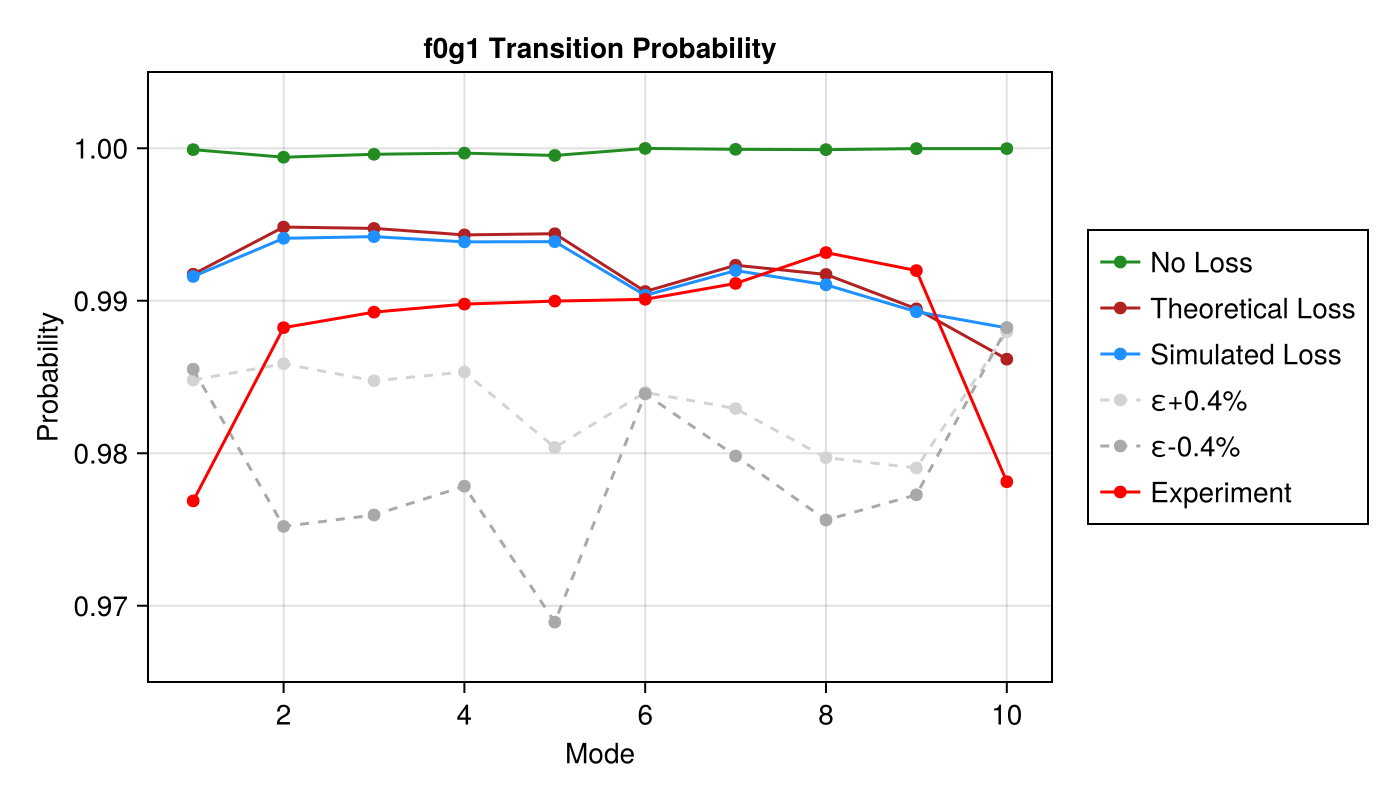

In [30]:
f = cm.Figure(size = (700, 400))
ax = cm.Axis(f[1, 1], xlabel = "Mode", ylabel = "Probability", title = "f0g1 Transition Probability", limits = (0.5, 10.5, 0.965, 1.005))

y = [Models[i].Stuff["op_drive_params"]["sb_f0g1"]["accuracy"] for i in 1:10]

cm.scatterlines!(ax, y, color = "forestgreen", label = "No Loss")
cm.scatterlines!(ax, predicted_loss, color = "firebrick", label = "Theoretical Loss")

y = [EVs_Loss[i][(0,1)][end] for i in 1:10]
cm.scatterlines!(ax, real.(y), color = "dodgerblue", label = "Simulated Loss")

y = [EVs_Loss_Upper[i][(0,1)][end] for i in 1:10]
cm.scatterlines!(ax, real.(y), color = "lightgrey", label = "ε+0.4%", linestyle = :dash)

y = [EVs_Loss_Lower[i][(0,1)][end] for i in 1:10]
cm.scatterlines!(ax, real.(y), color = "darkgrey", label = "ε-0.4%", linestyle = :dash)

cm.scatterlines!(ax, experimental_data, color = "red", label = "Experiment")

cm.Legend(f[1,2], ax)

display(f);

In [ ]:
f0g1_fidelities_dict = Dict{Any, Any}()

f0g1_fidelities_dict["No_Loss"] = [Models[i].Stuff["op_drive_params"]["sb_f0g1"]["accuracy"] for i in 1:10]
f0g1_fidelities_dict["Theoretical_Loss"] = predicted_loss
f0g1_fidelities_dict["Simulated_Loss"] = real.([EVs_Loss[i][(0,1)][end] for i in 1:10])
f0g1_fidelities_dict["Simulated_Loss, +0.4%"] = real.([EVs_Loss_Upper[i][(0,1)][end] for i in 1:10])
f0g1_fidelities_dict["Simulated_Loss, -0.4%"] = real.([EVs_Loss_Lower[i][(0,1)][end] for i in 1:10])
f0g1_fidelities_dict["Experimental"] = experimental_data

#open("f0g1_fidelities.json", "w") do f
#     JSON3.pretty(f, f0g1_fidelities_dict)
#end

# Looking at Drive Strength Drift

In [36]:
Model = Models[3]
Model.Stuff["op_drive_params"]["sb_f0g1_upper"] = deepcopy(Model.Stuff["op_drive_params"]["sb_f0g1"])
Model.Stuff["op_drive_params"]["sb_f0g1_upper"]["epsilon"] *= 1+0.004
Model.Stuff["op_drive_params"]["sb_f0g1_lower"] = deepcopy(Model.Stuff["op_drive_params"]["sb_f0g1"])
Model.Stuff["op_drive_params"]["sb_f0g1_lower"]["epsilon"] *= 1-0.004;

In [37]:
stroboscopic_times = SC.Dynamics.Get_Stroboscopic_Times(Model.Stuff["op_drive_params"]["sb_f0g1"]);

In [38]:
ψ = Model.dressed_states[(2,0)]
upper_res = SC.Dynamics.RunPulseSequence(Model, ψ, ["sb_f0g1_upper"], spns = "Stroboscopic");
lower_res = SC.Dynamics.RunPulseSequence(Model, ψ, ["sb_f0g1_lower"], spns = "Stroboscopic");

The Name for this run is: Operator_Sequence_Wed-Nov-20-24.14.22
It is being saved at: Data/
[2024-11-20 14:22:53] Info: Running operator sb_f0g1_upper
[2024-11-20 14:22:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-20 14:22:56] Info: Time Evolution Complete
[2024-11-20 14:22:56] Info: Saving Steps
[2024-11-20 14:22:57] Info: Done with Step_1
[2024-11-20 14:22:57] Info: Done With Running Sequence
[2024-11-20 14:22:57] Info: Loading Data
The Name for this run is: Operator_Sequence_Wed-Nov-20-24.14.22
It is being saved at: Data/
[2024-11-20 14:22:57] Info: Running operator sb_f0g1_lower
[2024-11-20 14:22:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-20 14:23:00] Info: Time Evolution Complete
[2024-11-20 14:23:00] Info: Saving Steps
[2024-11-20 14:23:01] Info: Done with Step_1
[2024-11-20 14:23:01] Info: Do

## Plotting State Evolution

[2024-11-20 14:23:01] Info: Making Plot
[2024-11-20 14:23:02] Info: Making Plot


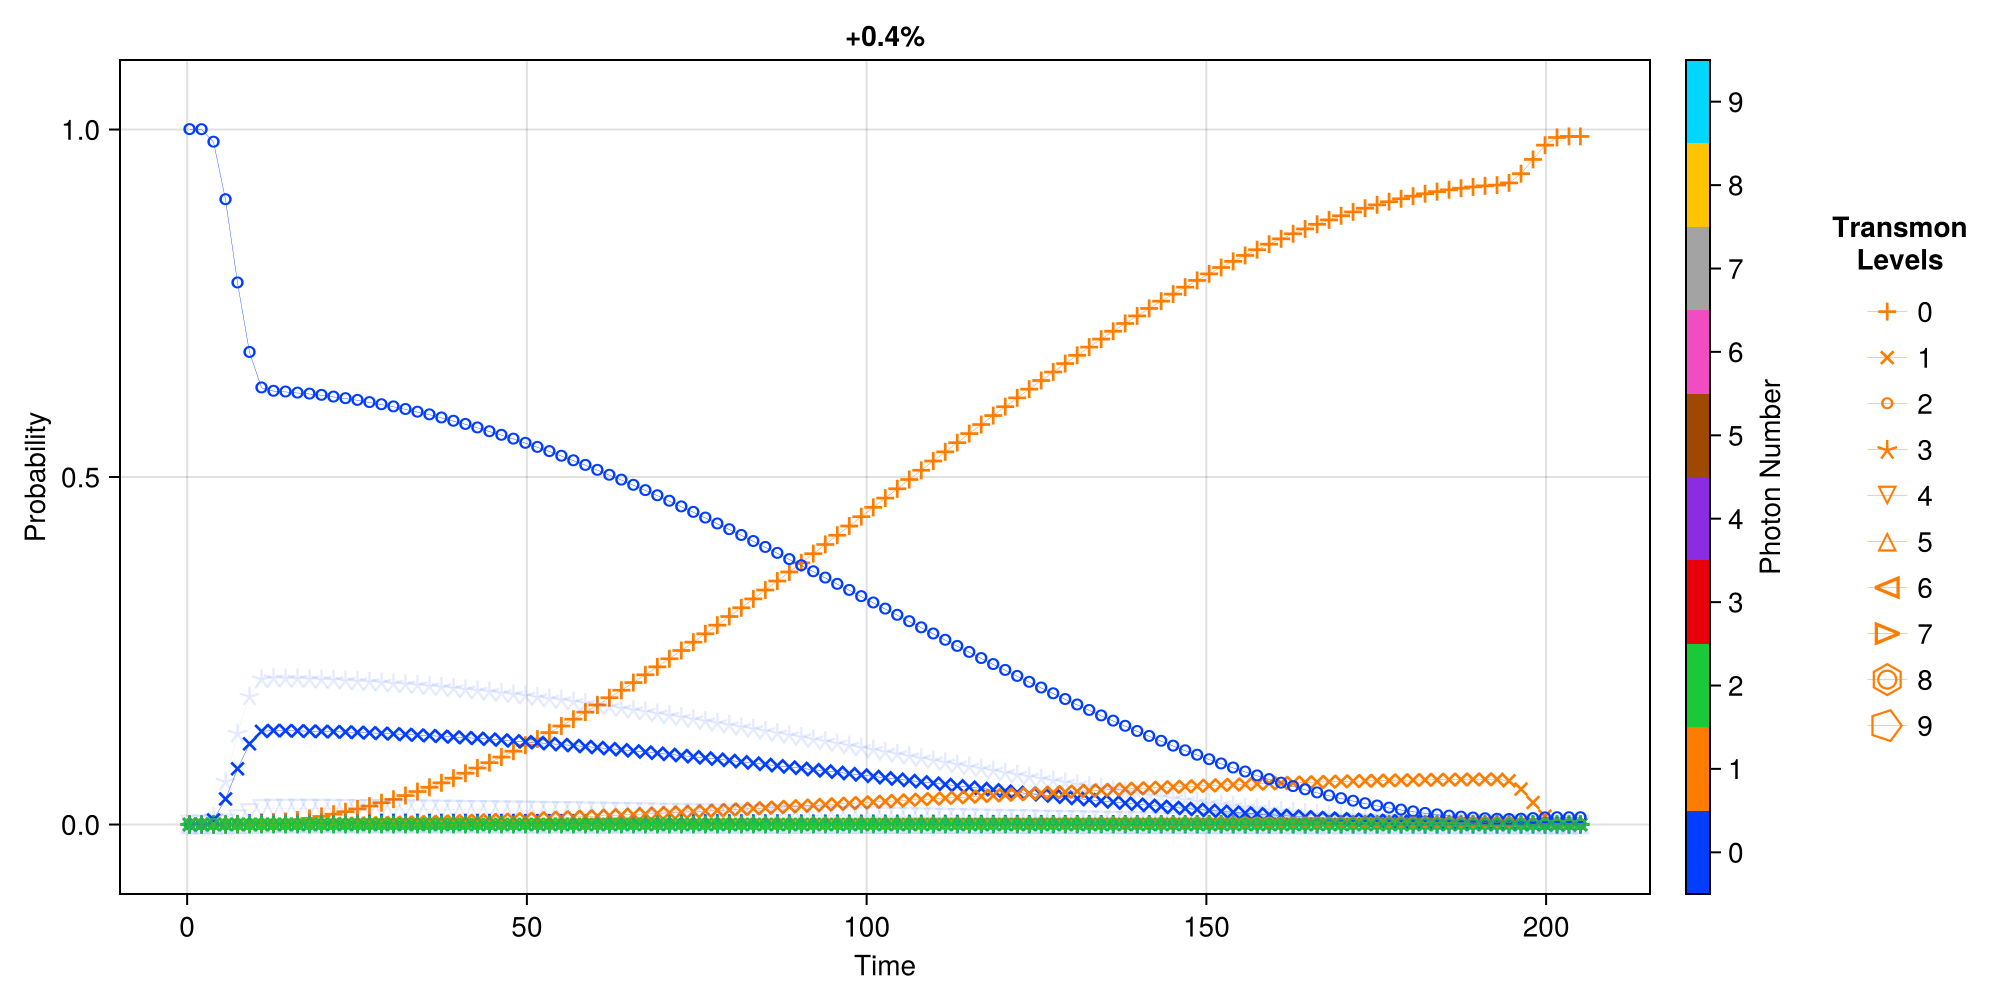

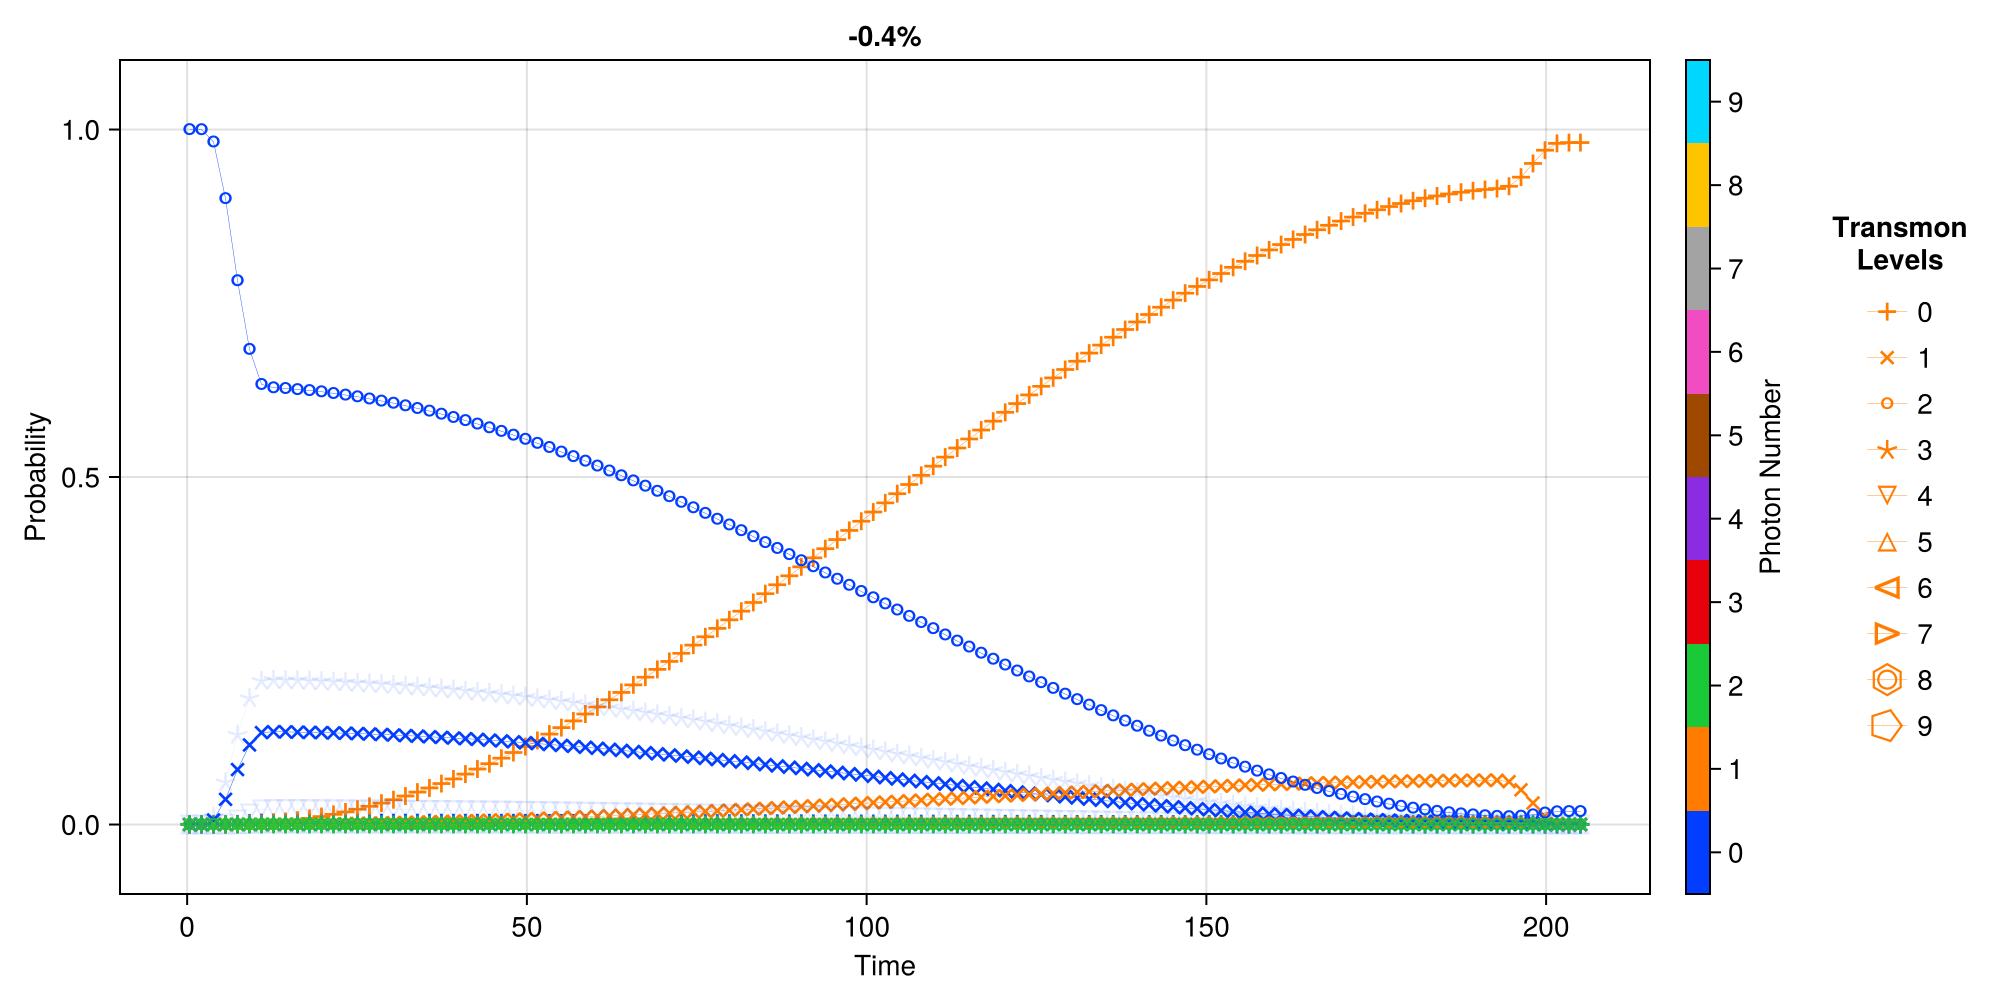

CairoMakie.Screen{IMAGE}


In [39]:
emphisize_states = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1), (0,2), (1,2), (2,2)]
SC.Dynamics.PlotSingleModeEvolution(Model, upper_res["times"], upper_res["states"], plot_every = 5, axis_kwargs = Dict{Any, Any}("title" => "+0.4%"), emph_states = emphisize_states)
SC.Dynamics.PlotSingleModeEvolution(Model, lower_res["times"], lower_res["states"], plot_every = 5, axis_kwargs = Dict{Any, Any}("title" => "-0.4%"), emph_states = emphisize_states)

## Looking at Floquet

In [40]:
states_to_track = Dict{Any, Any}((0,1) => Model.dressed_states[(0,1)], (2,0) => Model.dressed_states[(2,0)])
floquet_modes_upper = SC.Dynamics.Get_Pulse_Floquet_Sweep(Model.hilbertspace, Model.n̂ₜ, Model.Stuff["op_drive_params"]["sb_f0g1_upper"], states_to_track = states_to_track);
floquet_modes_lower = SC.Dynamics.Get_Pulse_Floquet_Sweep(Model.hilbertspace, Model.n̂ₜ, Model.Stuff["op_drive_params"]["sb_f0g1_lower"], states_to_track = states_to_track);

[2024-11-20 14:23:21] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[2024-11-20 14:23:57] Info: Done With Floquet Sweep
[2024-11-20 14:23:57] Info: Tracking State
[2024-11-20 14:23:57] Info: Running the necessary time evolutions
[2024-11-20 14:23:57] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-11-20 14:24:37] Info: Done With Floquet Sweep
[2024-11-20 14:24:37] Info: Tracking State
[2024-11-20 14:24:37] Info: Running the necessary time evolutions


In [41]:
floq_projections_upper = SC.Dynamics.Pulse_Floquet_Projections(upper_res["states"], floquet_modes_upper);
floq_projections_lower = SC.Dynamics.Pulse_Floquet_Projections(lower_res["states"], floquet_modes_lower);

[2024-11-20 14:24:37] Info: Making Plot
[2024-11-20 14:24:38] Info: Making Plot


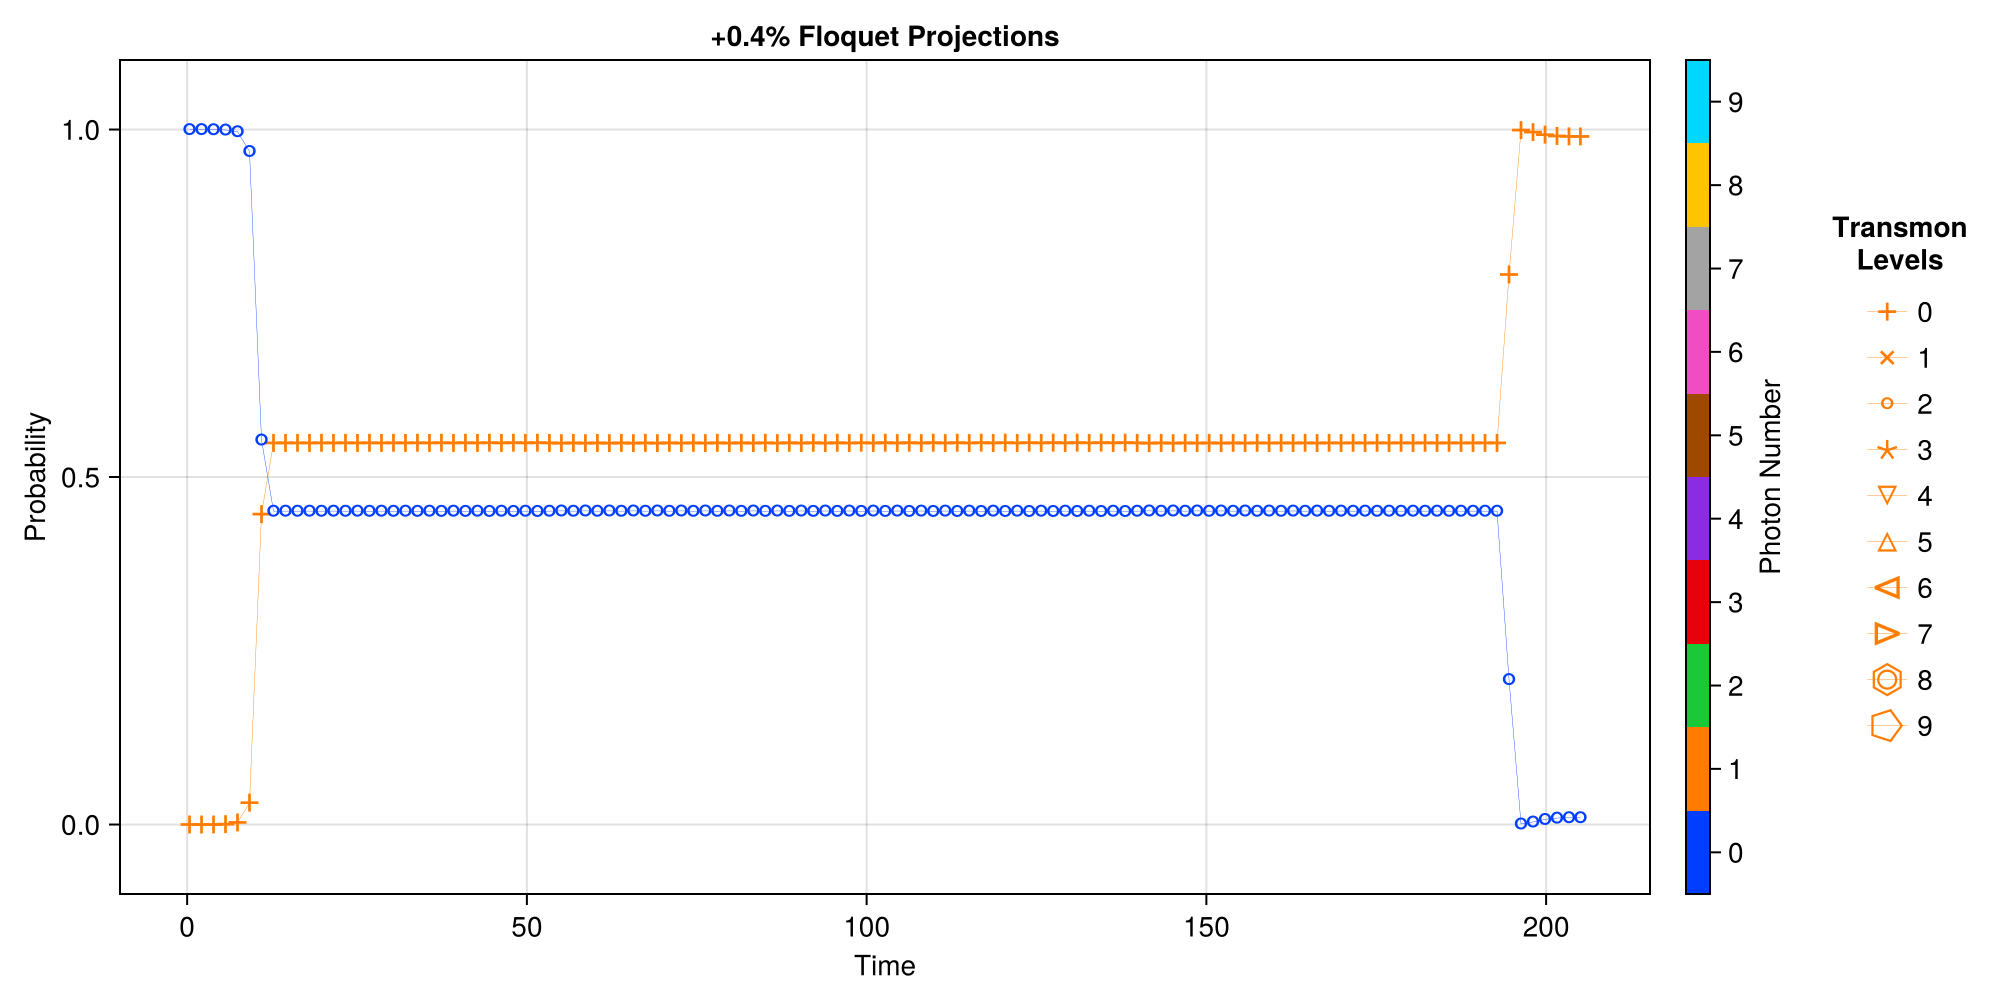

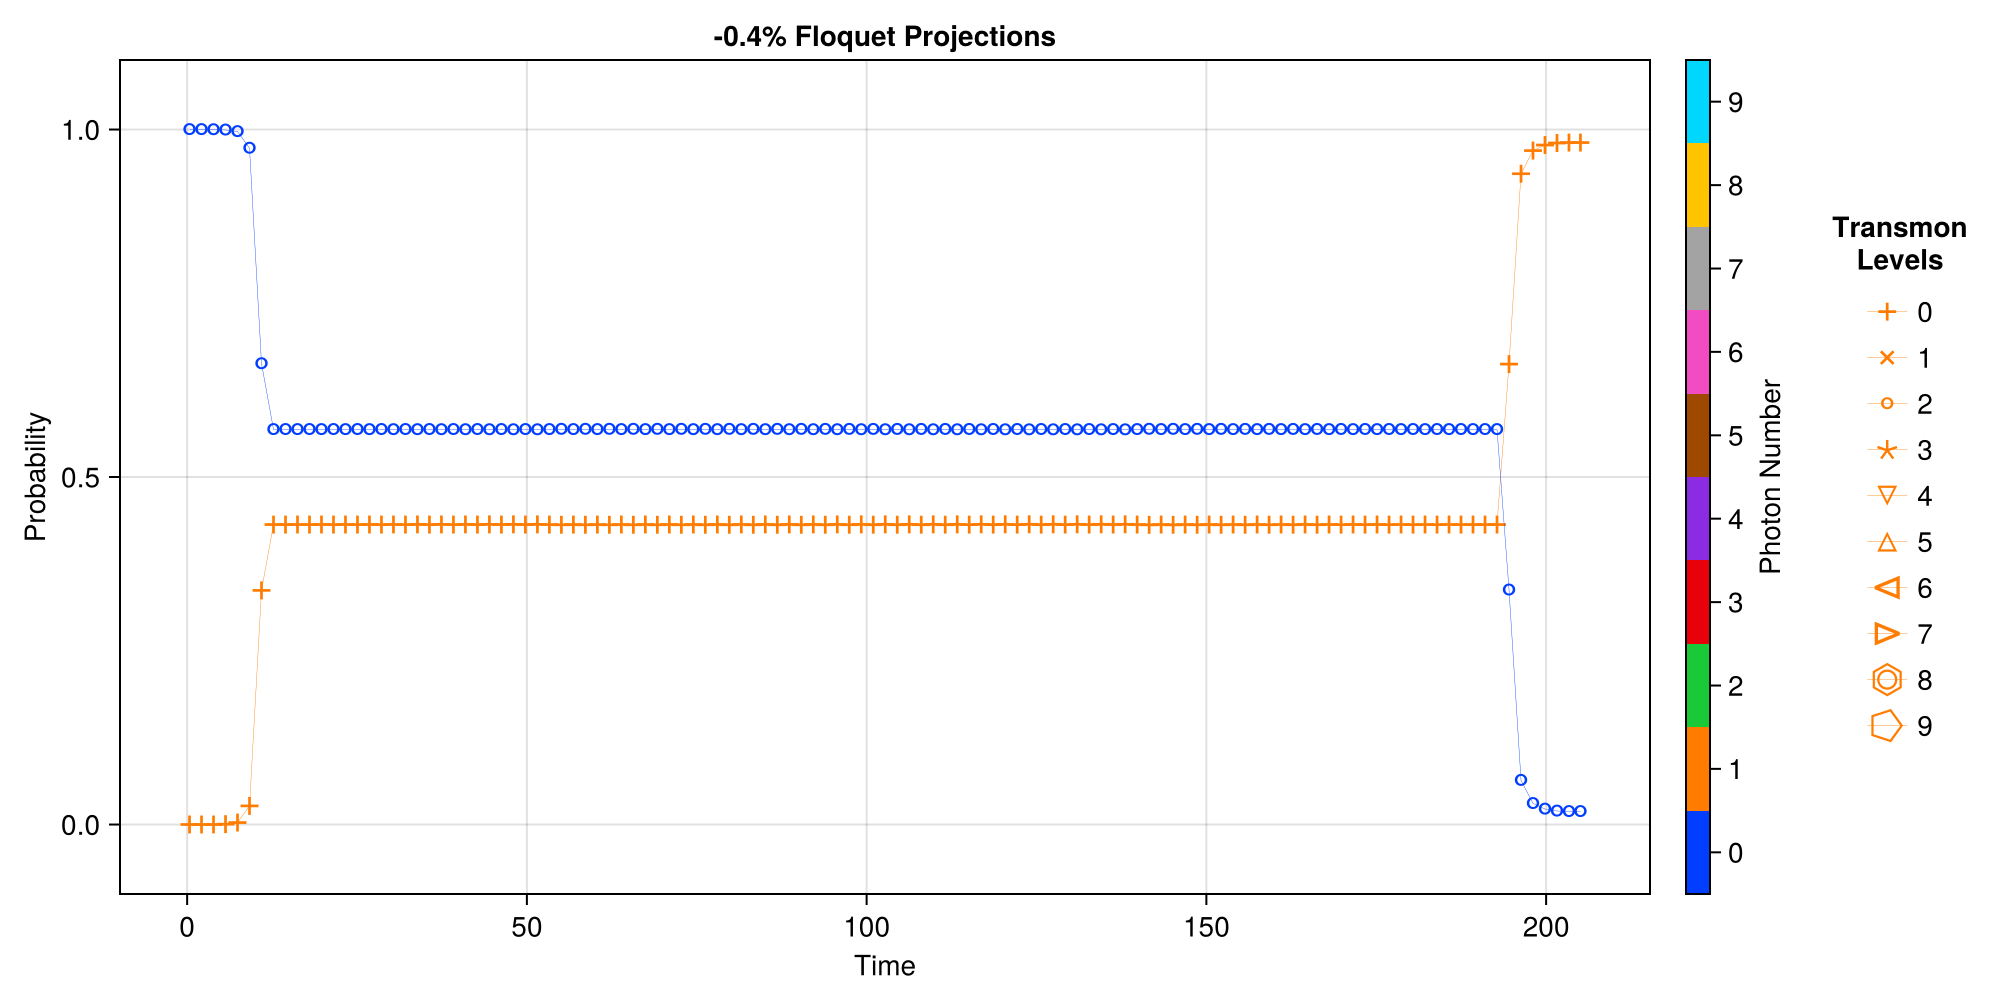

CairoMakie.Screen{IMAGE}


In [42]:
SC.Dynamics.PlotSingleModeEvolution(Model, upper_res["times"], floq_projections_upper, plot_every = 5, axis_kwargs = Dict{Any, Any}("title" => "+0.4% Floquet Projections"), emph_states = emphisize_states)
SC.Dynamics.PlotSingleModeEvolution(Model, lower_res["times"], floq_projections_lower, plot_every = 5, axis_kwargs = Dict{Any, Any}("title" => "-0.4% Floquet Projections"), emph_states = emphisize_states)

In [52]:
println(floq_projections_upper[string((0,1))][200])
println(floq_projections_upper[string((2,0))][200])
println(abs(floq_projections_upper[string((0,1))][200]-floq_projections_upper[string((2,0))][200]))
println("")
println(floq_projections_lower[string((0,1))][200])
println(floq_projections_lower[string((2,0))][200])
println(abs(floq_projections_lower[string((0,1))][200]-floq_projections_lower[string((2,0))][200]))

println("")
println(abs(abs(floq_projections_lower[string((0,1))][200]-floq_projections_lower[string((2,0))][200])-abs(floq_projections_upper[string((0,1))][200]-floq_projections_upper[string((2,0))][200])))

0.5494069586499786
0.4505690032947245
0.09883795535525408

0.4319054798927623
0.5680705239131912
0.13616504402042895

0.03732708866517487


In [45]:
length(floq_projections_upper[string((0,1))])

581